# Finding Climate Modes with EOFs

---

## Overview
In this notebook, we will identify and plot a few different modes of climate variability with the help of an EOF package that interfaces with Xarray called [`xeofs`](https://github.com/nicrie/xeofs).

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Intro to EOFs](eof-intro) | Helpful | |

- **Time to learn**: 30 minutes

---

## Imports

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.colors import CenteredNorm
from scipy import stats, signal
from cartopy import crs as ccrs, feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xeofs as xe

## Accessing and preparing the data

We will use the [NOAA Extended Reconstructed Sea Surface Temperature version 5 (ERSSTv5)](https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) monthly gridded dataset {cite:p}`Huang:2017a`, which is accessible using [OPeNDAP](https://www.opendap.org/). More information on [using OPeNDAP to access NOAA data can be found here](https://psl.noaa.gov/data/help/using_opendap.html).

In [2]:
data_url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'

In [30]:
sst = xr.open_dataset(data_url).sst
sst

<xarray.DataArray 'sst' (time: 2045, lat: 89, lon: 180)> Size: 131MB
[32760900 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2024-05-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

Check that the data looks as expected:

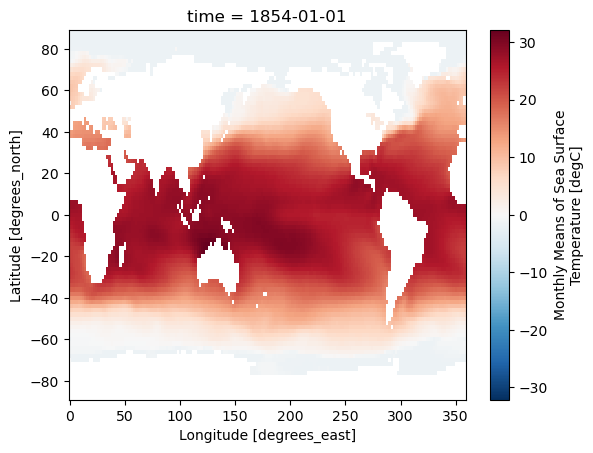

In [31]:
sst.isel(time=0).plot()

Before we modify the data, let's do an EOF analysis on the whole dataset:

In [5]:
s_model = xe.models.EOF(n_modes=4, use_coslat=True)
s_model.fit(sst, dim='time')
s_eofs = s_model.components()
s_pcs = s_model.scores()
s_expvar = s_model.explained_variance_ratio()

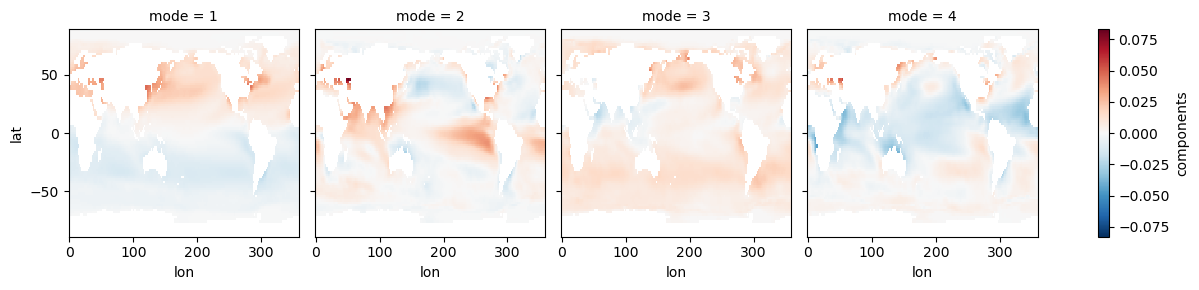

In [6]:
s_eofs.plot(col='mode')

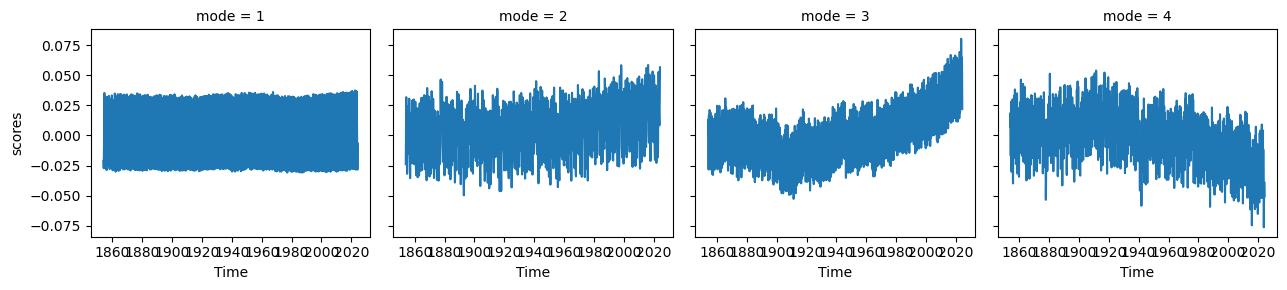

In [7]:
s_pcs.plot(col='mode')

In [8]:
s_expvar

<xarray.DataArray 'explained_variance_ratio' (mode: 4)> Size: 32B
array([0.82575411, 0.03647744, 0.02654952, 0.01653281])
Coordinates:
  * mode     (mode) int64 32B 1 2 3 4
Attributes: (12/16)
    model:          EOF analysis
    software:       xeofs
    version:        2.3.2
    date:           2024-06-07 15:13:21
    n_modes:        4
    center:         True
    ...             ...
    feature_name:   feature
    random_state:   None
    verbose:        False
    compute:        True
    solver:         auto
    solver_kwargs:  {}

EOF1 explains 83% of the variance, and the map shows interhemispheric asymmetry. The corresponding PC has a period of one year, which we can see more clearly by only plotting a few years:

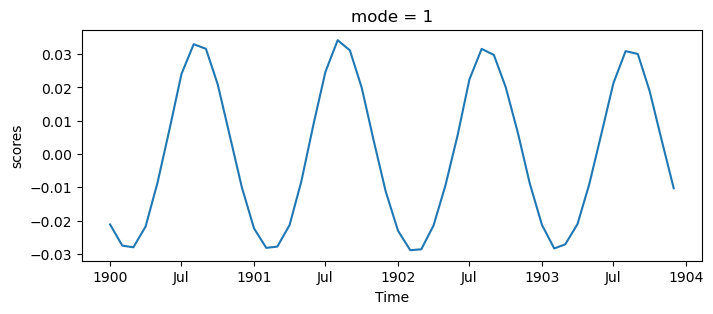

In [9]:
s_pcs.sel(mode=1, time=slice('1900', '1903')).plot(figsize=(8, 3))

This mode is showing the seasonal cycle. This is interesting, but it obfuscates other modes. If we want to study the other ways Earth's climate varies, we should remove the seasonal cycle from our data. Here we compute this (calling it the SST anomaly) by subtracting out the average of each month using Xarray's `.groupby()` method:

In [10]:
sst_clim = sst.groupby('time.month')
ssta = sst_clim - sst_clim.mean(dim='time')

The remaining 3 EOFs show a combination of the long-term warming trend, the seasonal cycle (EOF analyses do not cleanly separate physical modes), and other internal variability. The warming trend is also interesting (see the [CMIP6 Cookbook](https://projectpythia.org/cmip6-cookbook)), but here we want to pull out some modes of internal/natural variability. We can detrend the data by removing the global average SST anomaly.

In [11]:
def global_average(data):
    weights = np.cos(np.deg2rad(data.lat))
    data_weighted = data.weighted(weights)
    return data_weighted.mean(dim=['lat', 'lon'], skipna=True)

In [12]:
ssta_dt = (ssta - global_average(ssta)).squeeze()

Let's find the global EOFs again but with the deseasonalized, detrended data:

In [13]:
ds_model = xe.models.EOF(n_modes=4, use_coslat=True)
ds_model.fit(ssta_dt, dim='time')
ds_eofs = ds_model.components()
ds_pcs = ds_model.scores()
ds_expvar = ds_model.explained_variance_ratio()

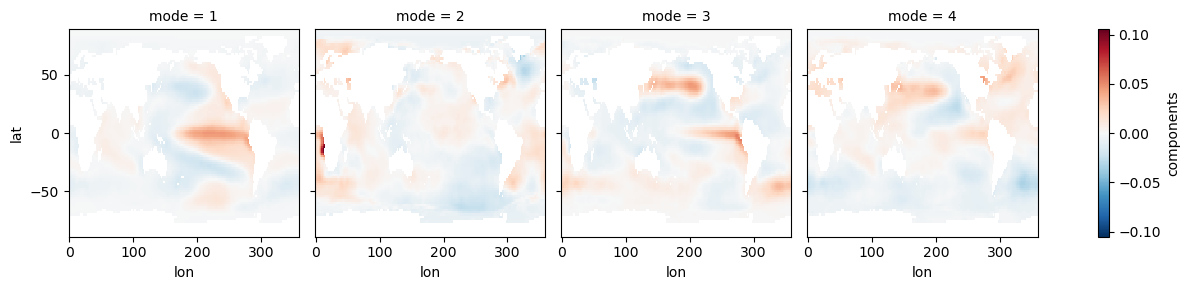

In [14]:
ds_eofs.plot(col='mode')

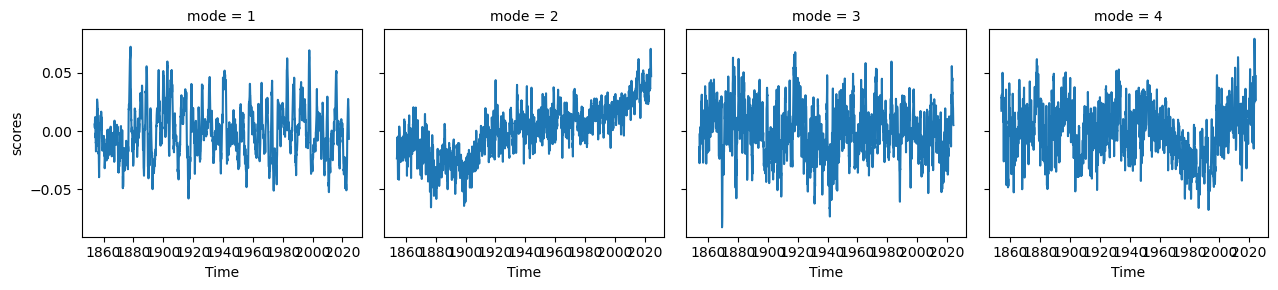

In [15]:
ds_pcs.plot(col='mode')

In [16]:
ds_expvar

<xarray.DataArray 'explained_variance_ratio' (mode: 4)> Size: 32B
array([0.12226184, 0.04733037, 0.034539  , 0.03201537])
Coordinates:
  * mode     (mode) int64 32B 1 2 3 4
Attributes: (12/16)
    model:          EOF analysis
    software:       xeofs
    version:        2.3.2
    date:           2024-06-07 15:14:36
    n_modes:        4
    center:         True
    ...             ...
    feature_name:   feature
    random_state:   None
    verbose:        False
    compute:        True
    solver:         auto
    solver_kwargs:  {}

Now we can see some modes of variability! EOF1 looks like ENSO or IPO, and EOF2 is probably picking up a pattern of the recent temperature trend where the Southern Ocean and southeastern Pacific are slightly cooling. EOF3 and EOF4 appear to be showing some decadal modes of variability (PDO and maybe AMO), among other things. There is a lot going on in each of these maps, so to get a clearer index of some modes, we can restrict our domain. 

## El Niño Southern Oscillation (ENSO)

Here we restrict our domain to the equatorial Pacific. Note that ENSO is commonly defined using an index of SST anomaly over a region of the equatorial Pacific (e.g., the [Oceanic Niño Index (ONI)](https://www.ncei.noaa.gov/access/monitoring/enso/sst)) instead of an EOF. You can [read more about ENSO here](https://www.ncei.noaa.gov/access/monitoring/enso/).

In [17]:
ep_ssta_dt = ssta_dt.where((ssta_dt.lat < 30) & (ssta_dt.lat > -30) & (ssta_dt.lon > 120) & (ssta_dt.lon < 290), drop=True)

In [18]:
ep_model = xe.models.EOF(n_modes=4, use_coslat=True)
ep_model.fit(ep_ssta_dt, dim='time')
ep_eofs = ep_model.components()
ep_pcs = ep_model.scores()
ep_expvar = ep_model.explained_variance_ratio()

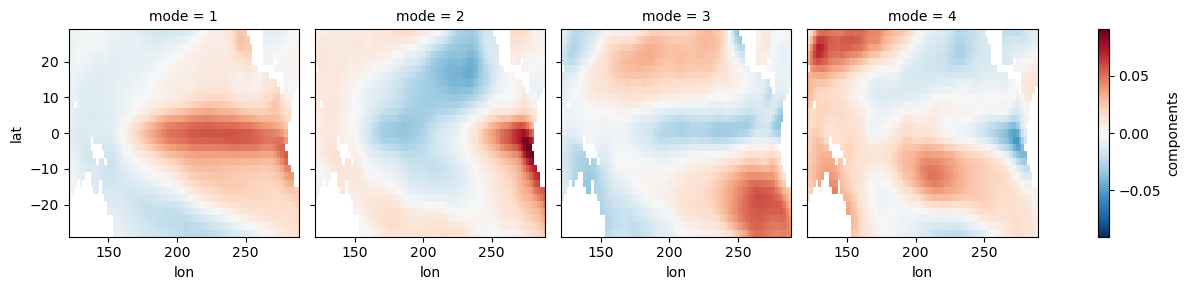

In [19]:
ep_eofs.plot(col='mode')

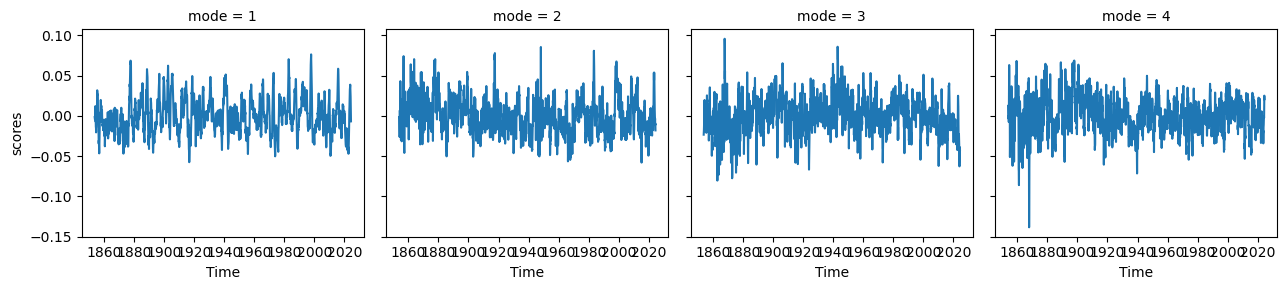

In [20]:
ep_pcs.plot(col='mode')

In [21]:
ep_expvar

<xarray.DataArray 'explained_variance_ratio' (mode: 4)> Size: 32B
array([0.32955431, 0.08712222, 0.05315635, 0.04717559])
Coordinates:
  * mode     (mode) int64 32B 1 2 3 4
Attributes: (12/16)
    model:          EOF analysis
    software:       xeofs
    version:        2.3.2
    date:           2024-06-07 15:14:39
    n_modes:        4
    center:         True
    ...             ...
    feature_name:   feature
    random_state:   None
    verbose:        False
    compute:        True
    solver:         auto
    solver_kwargs:  {}

Text(0.5, 1.0, 'ENSO Index (detrended equatorial Pacific SSTA EOF1)')

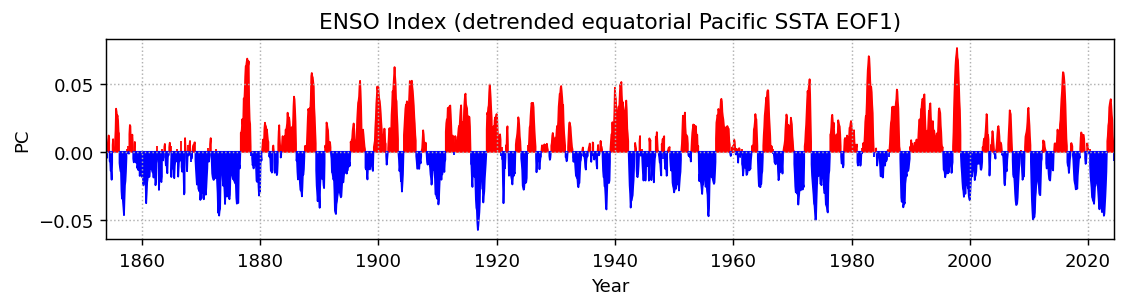

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2), dpi=130)
plt.fill_between(ep_pcs.time, ep_pcs.isel(mode=0).where(ep_pcs.isel(mode=0) > 0), color='r')
plt.fill_between(ep_pcs.time, ep_pcs.isel(mode=0).where(ep_pcs.isel(mode=0) < 0), color='b')
plt.ylabel('PC')
plt.xlabel('Year')
plt.xlim(ep_pcs.time.min(), ep_pcs.time.max())
plt.grid(linestyle=':')
plt.title('ENSO Index (detrended equatorial Pacific SSTA EOF1)')

Compare to the ONI:

Text(0.5, 1.0, 'ENSO Index (detrended equatorial Pacific SSTA EOF1)')

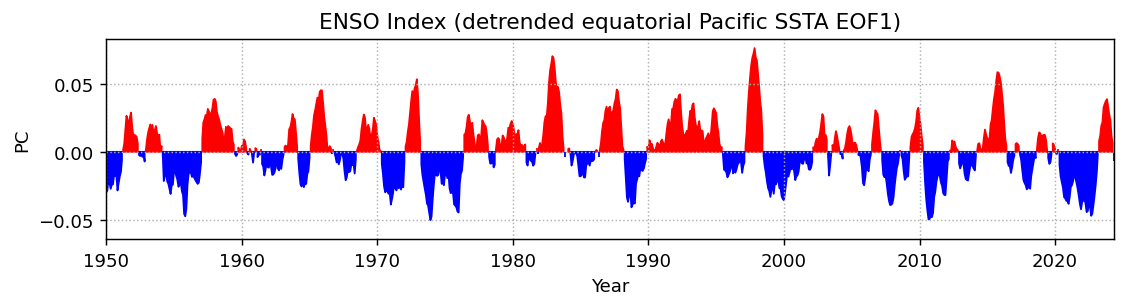

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2), dpi=130)
plt.fill_between(ep_pcs.time, ep_pcs.isel(mode=0).where(ep_pcs.isel(mode=0) > 0), color='r')
plt.fill_between(ep_pcs.time, ep_pcs.isel(mode=0).where(ep_pcs.isel(mode=0) < 0), color='b')
plt.ylabel('PC')
plt.xlabel('Year')
plt.xlim(ep_pcs.time.sel(time='1950-01').squeeze(), ep_pcs.time.max())
plt.grid(linestyle=':')
plt.title('ENSO Index (detrended equatorial Pacific SSTA EOF1)')

<img src="images/oni.png" alt="ONI"></img>

## Pacific Decadal Oscillation (PDO)

Here we restrict our domain to the North Pacific. You can [read more about PDO here](https://www.ncei.noaa.gov/access/monitoring/pdo/).

In [24]:
np_ssta_dt = ssta_dt.where((ssta_dt.lat < 70) & (ssta_dt.lat > 20) & (ssta_dt.lon > 120) & (ssta_dt.lon < 260), drop=True)

In [25]:
np_model = xe.models.EOF(n_modes=4, use_coslat=True)
np_model.fit(np_ssta_dt, dim='time')
np_eofs = np_model.components()
np_pcs = np_model.scores()
np_expvar = np_model.explained_variance_ratio()

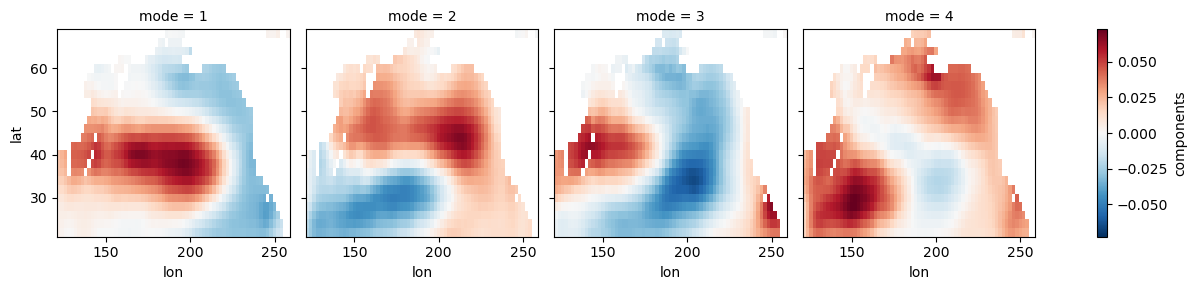

In [26]:
np_eofs.plot(col='mode')

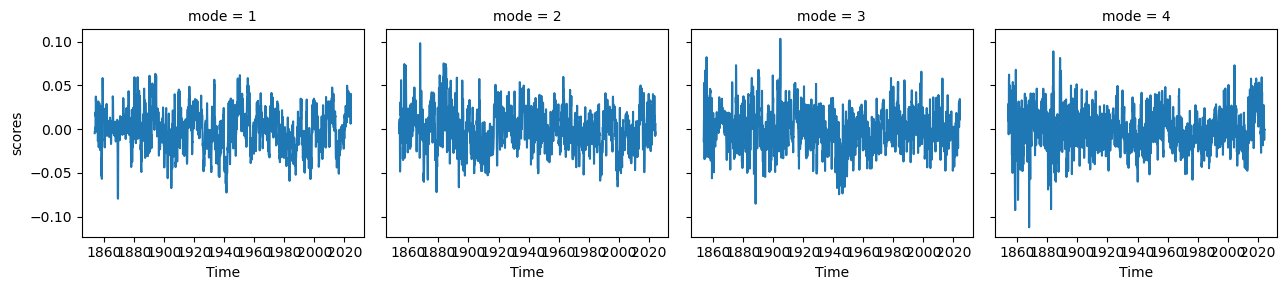

In [27]:
np_pcs.plot(col='mode')

In [28]:
np_expvar

<xarray.DataArray 'explained_variance_ratio' (mode: 4)> Size: 32B
array([0.17464065, 0.11074887, 0.072165  , 0.06702556])
Coordinates:
  * mode     (mode) int64 32B 1 2 3 4
Attributes: (12/16)
    model:          EOF analysis
    software:       xeofs
    version:        2.3.2
    date:           2024-06-07 15:14:57
    n_modes:        4
    center:         True
    ...             ...
    feature_name:   feature
    random_state:   None
    verbose:        False
    compute:        True
    solver:         auto
    solver_kwargs:  {}

Text(0.5, 1.0, 'PDO Index (detrended North Pacific SSTA EOF1)')

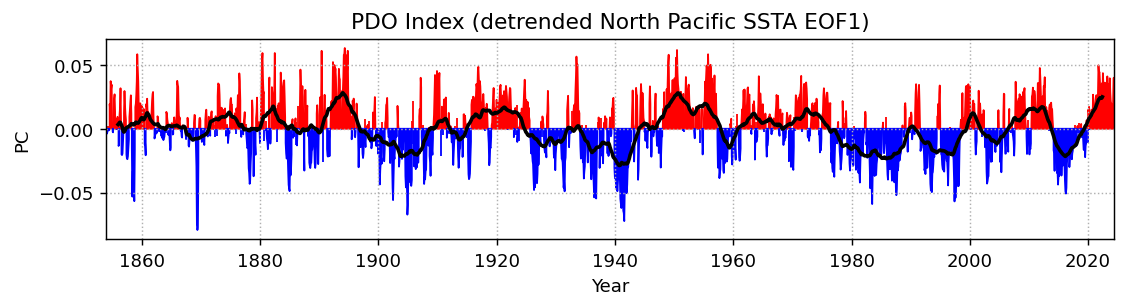

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2), dpi=130)
plt.fill_between(np_pcs.time, np_pcs.isel(mode=0).where(np_pcs.isel(mode=0) > 0), color='r')
plt.fill_between(np_pcs.time, np_pcs.isel(mode=0).where(np_pcs.isel(mode=0) < 0), color='b')
plt.plot(np_pcs.time, np_pcs.isel(mode=0).rolling(time=48, center=True).mean(), color='k', linewidth=2)
plt.ylabel('PC')
plt.xlabel('Year')
plt.xlim(np_pcs.time.min(), np_pcs.time.max())
plt.grid(linestyle=':')
plt.title('PDO Index (detrended North Pacific SSTA EOF1)')

---

## Summary
In this notebook, we demonstrated a basic workflow for performing an EOF analysis on gridded SST data using the `xeofs` package. We plotted the PCs associated with ENSO and PDO using deseasonalized, detrended SSTs.

### What's next?
In the future, additional notebooks may use EOFs to recreate published figures, give an overview of other EOF packages, or explore variations of the EOF method.

## Resources and references
1. Scientific description of the ERSSTv5 data set: [Huang et al. (2017), doi:10.1175/jcli-d-16-0836.1](https://doi.org/10.1175/jcli-d-16-0836.1)
1. [xeofs documentation](https://xeofs.readthedocs.io/)
2. Paper describing the xeofs software: [Rieger et al., (2024) doi:10.21105/joss.06060](https://doi.org/10.21105/joss.06060)